**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 4.1 Time Series Analysis**

## **Import the libraries and load the city temperature dataset**

First we have to import the necessary libraries to work within our project.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
import seaborn as sn

Clone the repository and load the dataset from it.

In [ ]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

fatal: destination path 'DataMiningProject' already exists and is not an empty directory.


In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
df_cities_temperatures = pd.read_csv('/content/DataMiningProject/DM_14_TASK4/CityGlobalTemperature.csv', sep=",", index_col=0, parse_dates=["time"], date_parser=dateparse)
df_cities_temperatures

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
1813,27.685,0.267,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-02-01
1814,29.061,0.224,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-03-01
1815,28.162,0.478,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-04-01
1816,27.547,0.509,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-05-01
1817,25.812,0.231,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-06-01
...,...,...,...,...,...,...,...
239128,18.459,0.374,Xian,China,34.56N,108.97E,2009-09-01
239129,14.195,0.163,Xian,China,34.56N,108.97E,2009-10-01
239130,2.916,0.675,Xian,China,34.56N,108.97E,2009-11-01
239131,-0.712,0.259,Xian,China,34.56N,108.97E,2009-12-01


In [ ]:
df_cities_temperatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1813 to 239132
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   AverageTemperature             12000 non-null  float64       
 1   AverageTemperatureUncertainty  12000 non-null  float64       
 2   City                           12000 non-null  object        
 3   Country                        12000 non-null  object        
 4   Latitude                       12000 non-null  object        
 5   Longitude                      12000 non-null  object        
 6   time                           12000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 750.0+ KB


## **Some time series plots**

Plot some time series to better understand how the dataset is built.

Build new dataframes (df_cities for the shape clustering analysis and df_cities_months to plot).

In [ ]:
df_cities = df_cities_temperatures.pivot(index="City", columns="time", values="AverageTemperature")
df_cities_months = df_cities_temperatures.pivot(index="time", columns="City", values="AverageTemperature")
df_cities

time,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,...,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abidjan,27.685,29.061,28.162,27.547,25.812,24.870,24.884,25.405,26.074,27.315,26.929,26.920,28.234,28.706,27.702,27.653,25.940,24.841,24.280,24.797,26.278,27.374,27.598,27.192,28.796,28.564,28.508,27.721,25.972,25.054,24.580,25.260,26.076,27.282,27.087,27.590,28.863,28.980,28.169,27.910,...,26.396,27.375,27.397,27.120,28.986,29.106,28.334,27.702,26.134,25.417,25.004,25.606,26.074,27.232,27.367,26.061,28.773,28.819,28.156,27.366,26.276,25.652,25.219,25.557,26.681,27.302,27.472,26.912,28.224,28.805,28.001,27.766,26.655,25.437,24.945,25.568,26.354,27.497,27.620,28.270
Addis Abeba,19.183,20.230,20.398,19.977,18.254,17.109,16.944,17.542,17.113,17.741,17.013,17.454,18.864,20.043,20.233,19.908,17.978,17.011,17.152,17.867,18.047,17.306,17.694,17.901,19.471,20.193,20.097,20.234,18.084,17.518,17.171,17.405,17.324,17.964,18.275,18.201,19.210,20.453,20.270,20.409,...,17.799,17.793,17.285,18.484,18.959,20.045,19.619,19.805,17.998,17.002,16.905,17.192,17.108,17.502,17.092,18.773,19.493,19.735,19.704,19.459,17.899,16.853,16.960,17.736,17.460,16.950,16.958,17.963,19.824,20.189,20.335,20.283,19.222,17.484,17.513,18.187,17.788,18.098,18.298,18.390
Ahmadabad,21.246,26.565,32.275,32.847,32.490,28.678,28.616,29.087,29.285,25.577,21.785,19.770,22.438,27.198,31.034,33.358,30.717,27.730,27.893,29.490,29.073,25.516,22.160,19.831,22.333,27.885,32.020,34.317,32.522,29.698,28.036,28.558,29.507,25.437,22.485,21.006,23.304,27.331,31.887,33.511,...,28.415,25.325,21.913,20.697,23.644,27.121,32.205,33.748,32.307,29.124,27.979,28.836,27.604,25.621,21.248,19.179,20.244,28.023,30.922,32.850,31.186,28.985,27.246,28.485,28.694,25.452,23.316,21.615,24.194,28.640,31.847,34.075,32.957,29.426,29.072,29.360,28.299,25.187,22.478,20.969
Aleppo,6.832,10.421,17.743,22.240,27.781,31.957,29.873,25.877,18.846,13.380,7.636,7.306,8.787,14.904,17.666,21.191,27.922,30.727,30.330,26.419,20.153,11.430,8.173,4.806,9.745,12.984,15.722,21.571,27.554,30.407,29.396,26.078,21.185,13.707,5.473,7.598,6.078,9.830,16.322,24.059,...,19.773,11.031,5.837,4.724,8.351,12.045,14.404,24.139,28.113,31.132,30.266,26.777,21.270,12.863,6.622,3.063,7.025,15.067,19.416,21.837,28.119,30.787,31.206,26.287,19.988,13.711,6.575,5.742,8.866,11.099,16.305,22.188,28.337,30.216,29.833,24.927,21.477,12.324,9.943,8.779
Alexandria,14.300,15.266,19.556,21.828,24.619,27.091,26.930,25.939,22.842,20.524,16.460,15.312,15.403,18.834,19.709,22.533,24.652,27.094,28.246,26.963,23.599,19.744,15.366,13.399,15.941,17.495,18.956,21.926,24.895,28.197,28.157,27.246,24.016,20.899,16.347,16.085,13.814,15.157,18.846,23.266,...,23.752,19.154,16.119,14.677,15.367,17.135,18.729,22.624,25.751,27.719,28.092,26.472,24.387,20.753,16.387,14.020,14.400,19.030,20.027,22.429,26.202,27.484,28.138,27.144,23.322,21.191,17.481,15.801,15.592,16.570,19.384,22.016,26.439,27.663,27.372,26.672,24.764,20.336,17.437,16.259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Plot the temperatures of three cities as an example.

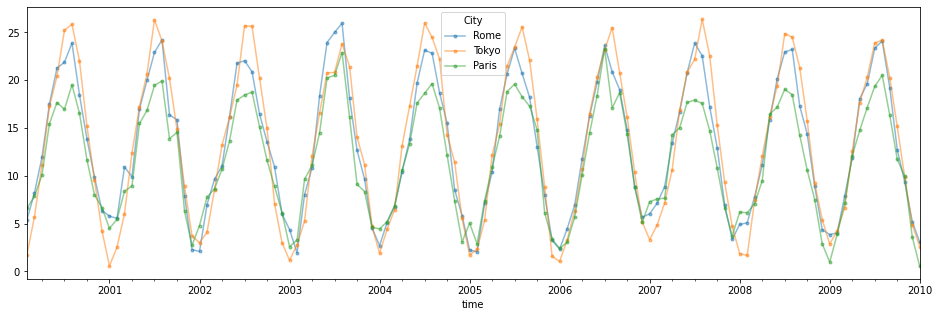

In [ ]:
df_cities_months[["Rome", "Tokyo", "Paris"]].plot(marker='.', alpha=0.5, figsize=(16, 5));

You can also plot the average temperature for each month during the period.

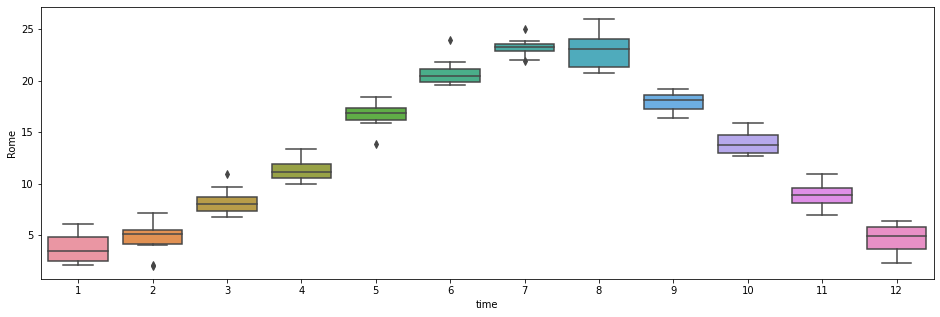

In [ ]:
plt.figure(figsize=(16, 5))
sn.boxplot(data=df_cities_months, x=df_cities_months.index.month, y="Rome");

## **Clustering**

Use shape-based clustering technique and show its results.

Import the libraries needed for the clustering techniques.

In [ ]:
!pip install tslearn

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.metrics.dtw_variants import pairwise_distances
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

Method for the k-means analysis to find the best k value.

In [ ]:
def k_means(x_cluster, i_cluster, max_k):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format(i_cluster, max_k)):
        kmeans_iter = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=max_k, random_state=0)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

Method to plot the SSE, Silhouette and Davies-Bouldin scores.

In [ ]:
def plot_indicators(i_cluster, max_k, sse_list, sil_list, davies_list):

    # plot indicators
    fig, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Dataframe {0}, indicators".format(i_cluster), fontsize=22)

### **Shape-based clustering**

Perform clustering based on the shape of the timeseries.

In [ ]:
sse, sil, davies_bouldin = k_means(df_cities, "Cities", 20)

Dataframe Cities, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Plot the results of the analysis (SSE, Silhouette and Davies-Bouldin scores) for each value of k.

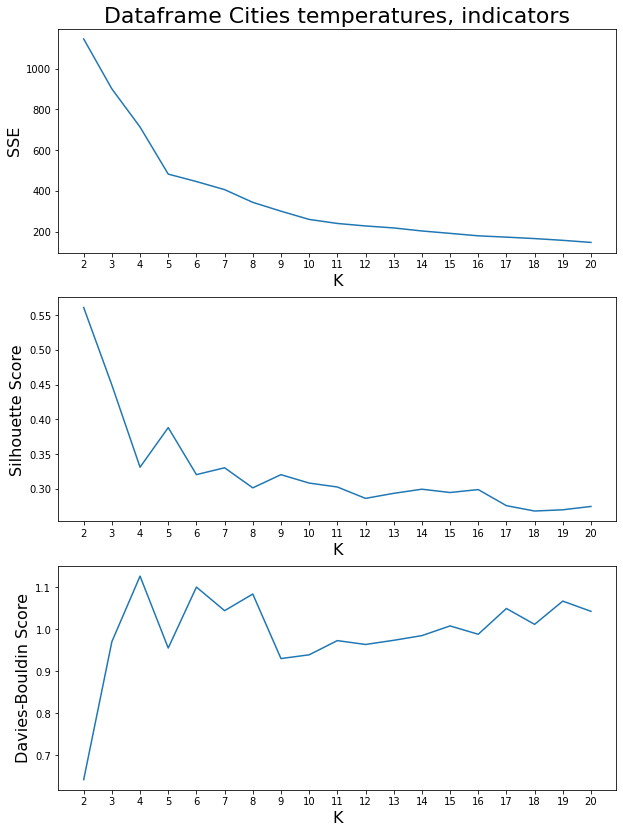

In [ ]:
plot_indicators("Cities temperatures", 20, sse, sil, davies_bouldin)

By using the elbow rule for the SSE graph and looking at the other two, we saw that the best value for k is 5, we proceed with our analysis.

In [ ]:
k = 5  # best k value
kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw")
kmeans.fit(df_cities)
print("SSE:", sse[k-2], " - SILHOUETTE:", sil[k-2])

SSE: 483.00006696354694  - SILHOUETTE: 0.3882569665611318


Let's see how many cities are in each cluster.

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 16, 1: 22, 2: 44, 3: 9, 4: 9}


Plot the clusters.

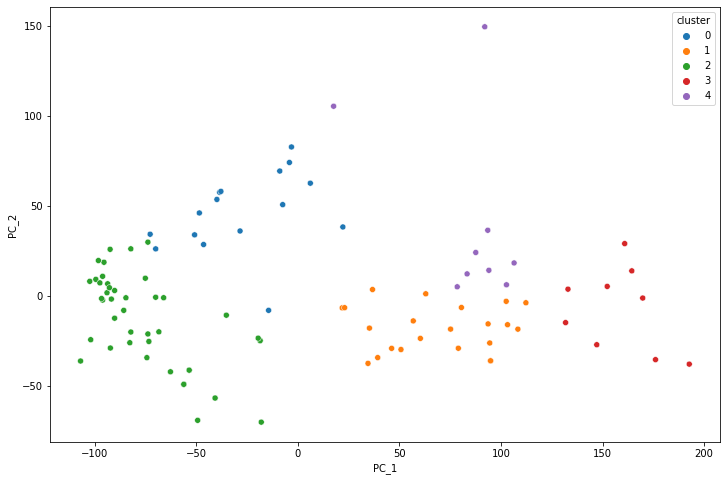

In [ ]:
pca = PCA(n_components=2)
scaler = TimeSeriesScalerMeanVariance()
df_pca = df_cities.copy()
df_pca.columns = df_pca.columns.astype(str)
df_pca_scaled = scaler.fit_transform(df_pca)
data_to_visualize = pd.DataFrame(pca.fit_transform(df_pca), columns=['PC_1','PC_2'], index=df_cities.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

In [ ]:
cluster_type = list()
cluster_colors = ["blue", "green", "orange", "red", "brown"]
cluster_name = ["Very cold winter, Mild summer", "Cold winter, Hot summer", "Warm winter, Mild summer", "Warm winter, Very hot summer", "Hot winter, Hot summer"]
for cluster in kmeans.cluster_centers_:
    cluster_type.append(cluster.mean())

cluster_type = pd.DataFrame(cluster_type, columns=["mean"])
cluster_type.sort_values("mean", inplace=True)
cluster_type["color"] = cluster_colors
cluster_type["name"] = cluster_name
cluster_type

,mean,color,name
3,6.215562,blue,"Very cold winter, Mild summer"
4,11.543568,green,"Cold winter, Hot summer"
1,15.566579,orange,"Warm winter, Mild summer"
0,20.633995,red,"Warm winter, Very hot summer"
2,26.994292,brown,"Hot winter, Hot summer"


In [ ]:
def plot_basic_statistics(df, labels, columns):
    df_plot = pd.DataFrame(df, columns=columns, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(19, 8))
    for i in np.unique(df_plot['cluster'].array):
        clust = df.loc[df_plot['cluster'] == i, df.columns.month==columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)
    legend = []
    for i in np.unique(df_plot['cluster'].array):
        cluster_color = cluster_type.loc[i, "color"]
        plt.plot(range(0, columns.shape[0]), means[i], marker='o', color=cluster_color)
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=89)
    plt.tight_layout()

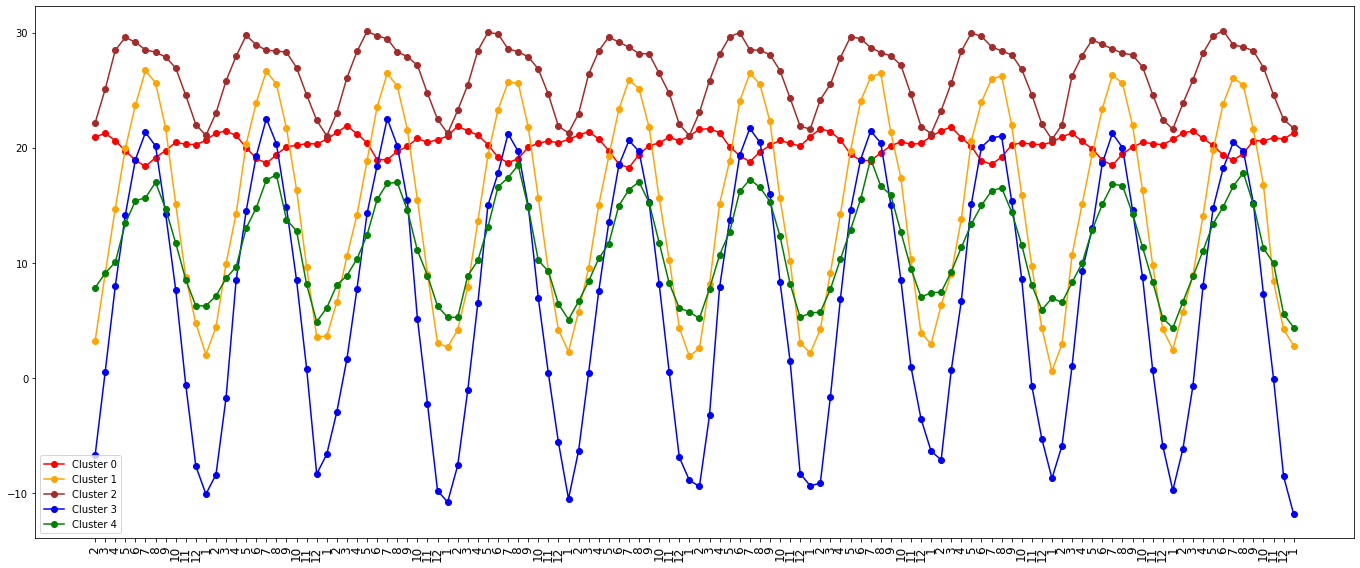

In [ ]:
clusters_cities = kmeans.labels_
plot_basic_statistics(df_cities, clusters_cities, df_cities.columns.month)

The cities are separated in five different cluster in accordance to their temperature trend:
* Warm winter and very hot summer.
* Cold winter and hot summer.
* Very hot winter and very hot summer.
* Warm winter and mild summer.
* Very cold winter and mild summer



In [ ]:
df_cities_plot = df_cities.copy()
df_cities_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cities_plot.groupby("cluster").mean()

time,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,...,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20.915813,21.247563,20.619437,19.719062,18.909438,18.365188,19.136250,19.745625,20.457875,20.297750,20.266062,20.626188,21.276063,21.432062,21.055875,19.995500,19.078437,18.628000,19.387625,20.080750,20.200437,20.348875,20.322437,20.724563,21.321375,21.900750,21.194125,20.428375,18.958750,18.941000,19.675250,20.110563,20.795000,20.459250,20.692000,21.003312,21.866250,21.457875,21.090250,20.254813,...,20.506750,20.294625,20.364500,20.973312,21.461063,21.798000,20.873500,20.106938,18.841438,18.556438,19.171500,20.232687,20.427812,20.291937,20.260000,20.468187,20.947312,21.264812,20.536125,19.904062,18.924437,18.460375,19.439563,20.054312,20.451937,20.355563,20.253125,20.711000,21.269000,21.452000,20.803250,20.195563,19.356063,18.913125,19.476813,20.618250,20.569000,20.864875,20.734750,21.298438
1,3.222227,9.069227,14.688682,19.928545,23.688227,26.701545,25.618864,21.705318,15.110409,8.764955,4.730045,2.026000,4.409273,9.927273,14.274773,20.320773,23.916500,26.631955,25.517545,21.679045,16.347773,9.642409,3.576364,3.631364,6.595545,10.563455,14.158591,18.874455,23.545500,26.440318,25.352591,21.566136,15.469682,9.016091,3.027136,2.677636,4.169727,7.917455,13.604455,19.325727,...,17.375000,10.300364,3.919364,2.940455,6.330318,9.007636,13.805318,20.573500,23.954364,25.954455,26.219091,21.956318,15.928364,9.694727,4.346727,0.595364,2.944091,10.688864,15.108500,19.429500,23.379273,26.292909,25.604773,21.941727,16.295773,9.814409,4.240455,2.465727,5.724182,8.930591,14.071091,19.782955,23.817818,26.072000,25.421591,21.578273,16.776773,8.402318,4.206455,2.805909
2,22.149068,25.082318,28.461295,29.581500,29.154705,28.492341,28.294886,27.872273,26.918000,24.547250,22.006909,21.060932,23.004227,25.803227,27.946932,29.746045,28.932818,28.455455,28.396886,28.290568,26.945909,24.586000,22.372500,21.020977,23.042295,26.059659,28.351864,30.097750,29.712136,29.460841,28.323750,27.898977,27.159841,24.713705,22.456955,21.239636,23.249977,25.451932,28.431455,30.001136,...,27.171205,24.622523,21.833159,21.228659,23.219614,25.593682,28.379455,29.957136,29.668432,28.773568,28.387023,28.071591,26.800955,24.599318,22.023250,20.718455,21.986795,26.232614,27.999932,29.376386,28.962182,28.581023,28.197114,28.056432,27.003523,24.605750,22.415295,21.616636,23.836614,25.884227,28.221318,29.700114,30.167727,28.920364,28.749614,28.402000,26.957523,24.587318,22.457114,21.686045
3,-6.714556,0.525000,7.959111,14.157556,18.959556,21.320000,20.145556,14.267889,7.661444,-0.611444,-7.668000,-10.090444,-8.394111,-1.726111,8.488000,14.528000,19.286889,22.524333,20.343000,14.816111,8.467667,0.802889,-8.343889,-6.621333,-2.929778,1.646111,7.747444,14.284000,18.437889,22.527444,20.167111,15.410667,5.135333,-2.239778,-9.802333,-10.777111,-7.599889,-1.044111,6.506111,14.988333,...,8.516222,0.969222,-3.554444,-6.360889,-7.113444,0.650889,6.672556,15.123000,20.049778,20.842667,21.000333,15.348667,8.576778,-0.688222,-5.306000,-8.725889,-5.874111,1.031667,9.312111,12.993222,18.636222,21.240333,20.003000,14.579778,8.727

Plot the map with all the cities and their respective clusters.

In [ ]:
import plotly.graph_objs as plt_go

df_cities_locations = df_cities_temperatures[["City", "Country", "Latitude", "Longitude"]].drop_duplicates().sort_values("City")
for i, city in df_cities_locations.iterrows():
    if "S" in city["Latitude"]:
        df_cities_locations.loc[i, "Latitude"] = "-" + df_cities_locations.loc[i, "Latitude"]
    
    df_cities_locations.loc[i, "Latitude"] = df_cities_locations.loc[i, "Latitude"][:-1]
    if "W" in city["Longitude"]:
        df_cities_locations.loc[i, "Longitude"] = "-" + df_cities_locations.loc[i, "Longitude"]
    
    df_cities_locations.loc[i, "Longitude"] = df_cities_locations.loc[i, "Longitude"][:-1]

df_cities_locations[["Longitude", "Latitude"]] = df_cities_locations[["Longitude", "Latitude"]].astype("Float32")
df_cities_locations["cluster"] = kmeans.labels_  # insert the column "cluster"

fig = plt_go.Figure()
for i, cluster in cluster_type.iterrows():
    df_cities_plot_map = df_cities_locations[df_cities_locations["cluster"]==i]
    fig.add_trace(plt_go.Scattergeo(
        mode = "markers",
        lon = df_cities_plot_map["Longitude"],
        lat = df_cities_plot_map["Latitude"],
        text = df_cities_plot_map['City'] + ", " + df_cities_plot_map["Country"],
        legendgroup = "Cluster " + str(i),
        name = cluster["name"],
        marker_color = cluster["color"],
    ))
fig.update_layout(title_text='Cities clusters')

fig.show()

### **Feature-based clustering**

Perform clustering based on some features chosen by ourselves.

Define the new features on which we will apply the clustering analysis.

In [ ]:
# use the dataframe based on the months to obtain the desired features
df_cities_mean_temperatures = df_cities_months.groupby(df_cities_months.index.month).mean()
df_cities_fbc = pd.DataFrame(df_cities_mean_temperatures.mean())
df_cities_fbc.columns = ["Mean_t"]
df_cities_fbc["Max_t"] = df_cities_mean_temperatures.max()
df_cities_fbc["Min_t"] = df_cities_mean_temperatures.min()
df_cities_fbc["Mean_t_spring"] = np.zeros(len(df_cities))
df_cities_fbc["Mean_t_summer"] = np.zeros(len(df_cities))
df_cities_fbc["Mean_t_autumn"] = np.zeros(len(df_cities))
df_cities_fbc["Mean_t_winter"] = np.zeros(len(df_cities))

# insert latitude and longitude in the dataframe
df_cities_features = df_cities_temperatures[["City", "Latitude", "Longitude"]].drop_duplicates().sort_values("City")
df_cities_fbc[["Latitude", "Longitude"]] = df_cities_features[["Latitude", "Longitude"]].to_numpy()

# fix the coordinates
for i, city in df_cities_fbc.iterrows():
    if "S" in city["Latitude"]:
        df_cities_fbc.loc[i, "Latitude"] = "-" + df_cities_fbc.loc[i, "Latitude"]
    
    df_cities_fbc.loc[i, "Latitude"] = df_cities_fbc.loc[i, "Latitude"][:-1]
    if "W" in city["Longitude"]:
        df_cities_fbc.loc[i, "Longitude"] = "-" + df_cities_fbc.loc[i, "Longitude"]
    
    df_cities_fbc.loc[i, "Longitude"] = df_cities_fbc.loc[i, "Longitude"][:-1]

df_cities_fbc[["Longitude", "Latitude"]] = df_cities_fbc[["Longitude", "Latitude"]].astype("Float32")

# calculate the mean temperatures for each season for every city
m_spring = [4, 5, 6]
m_summer = [7, 8, 9]
m_autumn = [10, 11, 12]
m_winter = [1, 2, 3]
cities_s_months = df_cities_mean_temperatures.loc[:, df_cities_mean_temperatures.columns.isin(df_cities_fbc.loc[df_cities_fbc["Latitude"]<0].index)]
cities_n_months = df_cities_mean_temperatures.loc[:, df_cities_mean_temperatures.columns.isin(df_cities_fbc.loc[df_cities_fbc["Latitude"]>0].index)]
# mean temperatures for those cities in the northern emisphere
df_cities_fbc.loc[df_cities_fbc["Latitude"]>0, "Mean_t_spring"] = cities_n_months[cities_n_months.index.isin(m_spring)].mean()
df_cities_fbc.loc[df_cities_fbc["Latitude"]>0, "Mean_t_summer"] = cities_n_months[cities_n_months.index.isin(m_summer)].mean()
df_cities_fbc.loc[df_cities_fbc["Latitude"]>0, "Mean_t_autumn"] = cities_n_months[cities_n_months.index.isin(m_autumn)].mean()
df_cities_fbc.loc[df_cities_fbc["Latitude"]>0, "Mean_t_winter"] = cities_n_months[cities_n_months.index.isin(m_winter)].mean()
# mean temperatures for those cities in the southern emisphere
df_cities_fbc.loc[df_cities_fbc["Latitude"]<0, "Mean_t_spring"] = cities_s_months[cities_s_months.index.isin(m_autumn)].mean()
df_cities_fbc.loc[df_cities_fbc["Latitude"]<0, "Mean_t_summer"] = cities_s_months[cities_s_months.index.isin(m_winter)].mean()
df_cities_fbc.loc[df_cities_fbc["Latitude"]<0, "Mean_t_autumn"] = cities_s_months[cities_s_months.index.isin(m_spring)].mean()
df_cities_fbc.loc[df_cities_fbc["Latitude"]<0, "Mean_t_winter"] = cities_s_months[cities_s_months.index.isin(m_summer)].mean()
df_cities_fbc

,Mean_t,Max_t,Min_t,Mean_t_spring,Mean_t_summer,Mean_t_autumn,Mean_t_winter,Latitude,Longitude
City,,,,,,,,,
Abidjan,26.930375,28.9006,24.8005,27.288200,25.163233,27.032300,28.237767,5.630000,-3.230000
Addis Abeba,18.351717,20.1868,17.0864,19.386967,17.278933,17.448633,19.292333,8.840000,38.110001
Ahmadabad,27.416742,33.5029,20.2431,32.368867,28.550233,25.237767,23.510100,23.309999,72.519997
Aleppo,18.345783,30.6218,6.0204,22.338700,28.934033,13.338167,8.772233,36.169998,37.790001
Alexandria,21.331192,27.8062,14.8878,22.221067,27.251033,20.196133,15.656533,31.350000,30.160000
...,...,...,...,...,...,...,...,...,...
Tokyo,13.370042,24.9984,2.0084,16.403667,23.487200,9.685000,3.904300,36.169998,139.229996
Toronto,6.934975,19.6951,-6.8175,11.824533,18.299633,2.579400,-4.963667,44.200001,-80.500000
Umm Durman,29.882492,34.5343,23.1234,33.874233,31.481200,28.315100,25.859433,15.270000,32.500000


Look for the best value of k beetween 19 different values.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def k_means_feature_based(x_cluster, i_cluster, max_k):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format(i_cluster, max_k)):
        kmeans_iter = KMeans(n_clusters=k, max_iter=max_k, random_state=0)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

sse, sil, davies_bouldin = k_means_feature_based(df_cities_fbc.loc[:, ~df_cities_fbc.columns.isin(["Latitude", "Longitude"])], "Cities feature-based", 20)

Dataframe Cities feature-based, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Plot the results of the analysis (SSE, Silhouette and Davies-Bouldin scores) for each value of k.

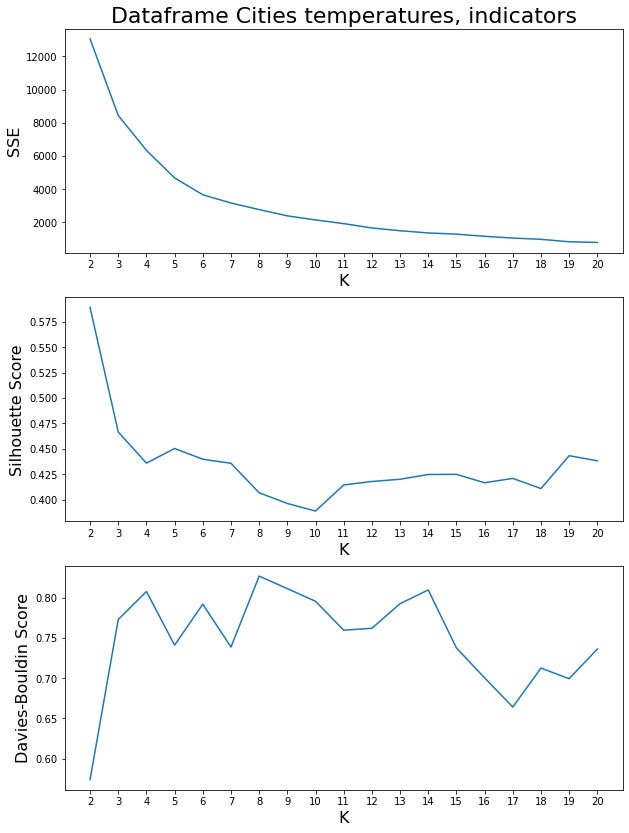

In [ ]:
plot_indicators("Cities temperatures", 20, sse, sil, davies_bouldin)

By using the elbow rule for the SSE graph and looking at the other two, we saw that the best value for k is 5, we proceed with our analysis.

In [ ]:
k = 5  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(df_cities_fbc.loc[:, ~df_cities_fbc.columns.isin(["Latitude", "Longitude"])])
print("SSE:", sse[k-2], " - SILHOUETTE:", sil[k-2])

SSE: 4681.174872410306  - SILHOUETTE: 0.4503238547831284


Let's see how many cities are in each cluster.

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 27, 1: 33, 2: 17, 3: 10, 4: 13}


Plot the clusters.

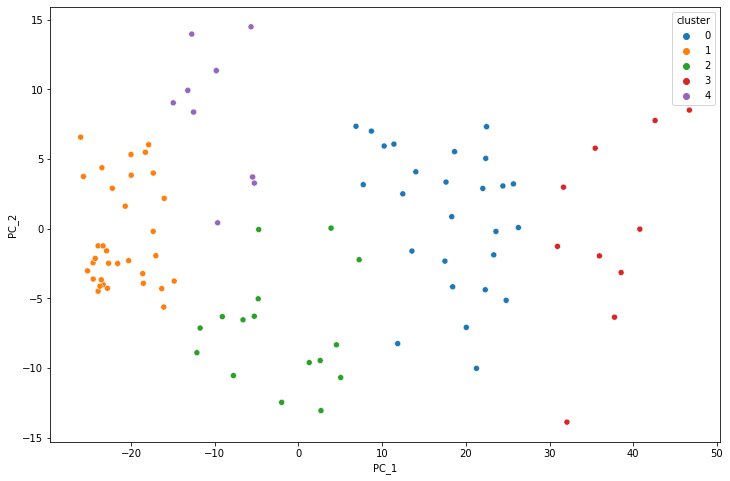

In [ ]:
pca = PCA(n_components=2)
scaler = StandardScaler()
df_pca = df_cities_fbc.loc[:, ~df_cities_fbc.columns.isin(["Latitude", "Longitude"])].copy()
df_pca.columns = df_pca.columns.astype(str)
df_pca_scaled = scaler.fit_transform(df_pca)
data_to_visualize = pd.DataFrame(pca.fit_transform(df_pca), columns=['PC_1','PC_2'], index=df_cities_fbc.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

In [ ]:
cluster_type = list()
cluster_colors = ["blue", "green", "orange", "red", "brown"] # , "purple", "black", "pink"] # , "yellow", "gray", "white"]
cluster_name = ["Very cold winter, Mild summer", "Cold winter, Hot summer", "Warm winter, Mild summer", "Warm winter, Very hot summer", "Hot winter, Hot summer"]
for cluster in kmeans.cluster_centers_:
    cluster_type.append(cluster.mean())

cluster_type = pd.DataFrame(cluster_type, columns=["mean"])
cluster_type.sort_values("mean", inplace=True)
cluster_type["color"] = cluster_colors
cluster_type["name"] = cluster_name
cluster_type

,mean,color,name
3,6.552488,blue,"Very cold winter, Mild summer"
0,13.467717,green,"Cold winter, Hot summer"
2,19.303336,orange,"Warm winter, Mild summer"
4,24.278995,red,"Warm winter, Very hot summer"
1,26.869049,brown,"Hot winter, Hot summer"


In [ ]:
def plot_basic_statistics_fbc(df, labels, columns):
    df_plot = pd.DataFrame(df, columns=columns, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(19, 8))
    for i in np.unique(df_plot['cluster'].array):
        clust = df.loc[df_plot['cluster'] == i]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)
    legend = []
    for i in np.unique(df_plot['cluster'].array):
        cluster_color = cluster_type.loc[i, "color"]
        plt.plot(range(0, columns.shape[0]), means[i], marker='o', color=cluster_color)
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=89)
    plt.tight_layout()

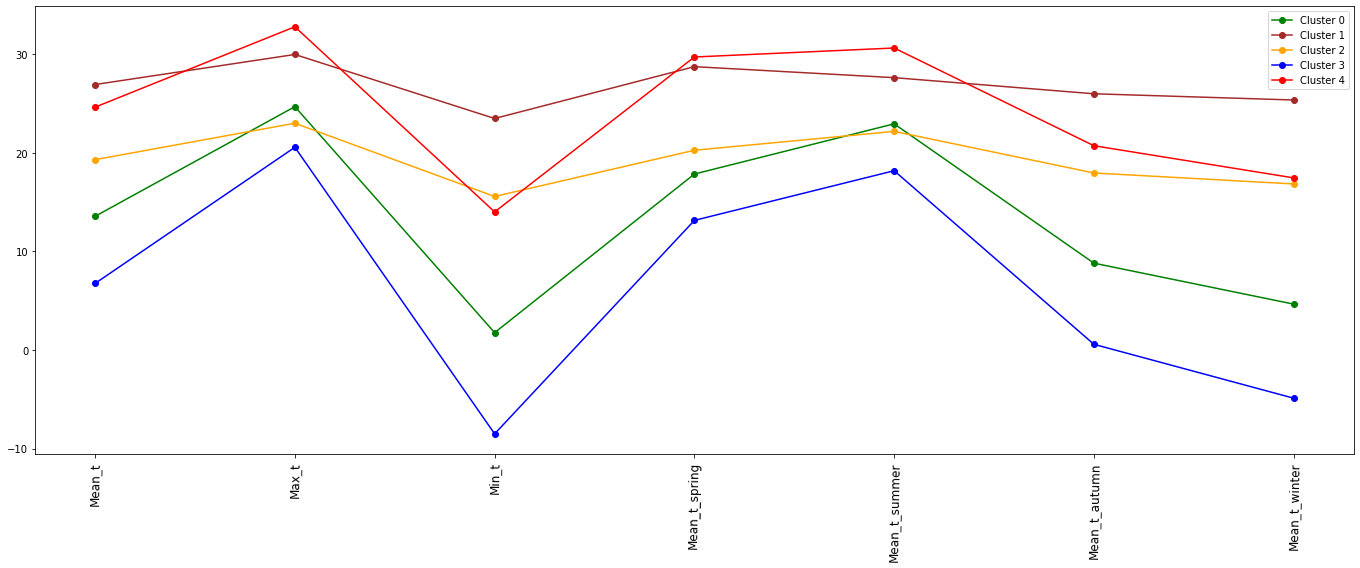

In [ ]:
clusters_cities = kmeans.labels_
plot_basic_statistics_fbc(df_cities_fbc.loc[:, ~df_cities_fbc.columns.isin(["Latitude", "Longitude"])], clusters_cities, df_cities_fbc.loc[:, ~df_cities_fbc.columns.isin(["Latitude", "Longitude"])].columns)

In [ ]:
df_cities_fbc_plot = df_cities_fbc.copy()
df_cities_fbc_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cities_fbc_plot.loc[:, ~df_cities_fbc_plot.columns.isin(["Latitude", "Longitude"])].groupby("cluster").mean()

,Mean_t,Max_t,Min_t,Mean_t_spring,Mean_t_summer,Mean_t_autumn,Mean_t_winter
cluster,,,,,,,
0,13.565180,24.681796,1.766322,17.849693,22.939765,8.812391,4.658870
1,26.925927,29.972367,23.481342,28.737200,27.622744,25.987520,25.356244
2,19.309531,23.001359,15.574341,20.260410,22.175424,17.957767,16.844524
3,6.759877,20.563700,-8.495670,13.148970,18.187037,0.583160,-4.879660
4,24.632072,32.783592,14.009015,29.717897,30.629382,20.720185,17.460823


Plot the map with all the cities and their respective clusters.

In [ ]:
import plotly.graph_objs as plt_go
df_cities_fbc_locations = df_cities_temperatures[["City", "Country"]].drop_duplicates().sort_values("City")
df_cities_fbc_plot["Country"] = list(df_cities_fbc_locations["Country"])

fig = plt_go.Figure()
for i, cluster in cluster_type.iterrows():
    df_cities_fbc_plot_map = df_cities_fbc_plot[df_cities_fbc_plot["cluster"]==i]
    fig.add_trace(plt_go.Scattergeo(
        mode = "markers",
        lon = df_cities_fbc_plot_map["Longitude"],
        lat = df_cities_fbc_plot_map["Latitude"],
        text = df_cities_fbc_plot_map.index + ", " + df_cities_fbc_plot_map["Country"],
        legendgroup = "Cluster " + str(i),
        name = cluster["name"],
        marker_color = cluster["color"],
    ))
fig.update_layout(title_text='Cities clusters')

fig.show()